# Oral Cancer Classification

## Train Test Split

In [2]:
import os
import shutil
import pathlib

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16

In [13]:
original_dir = pathlib.Path("Content_3class_new")
new_base_dir = pathlib.Path("oral_cancer_train_test_split")

def make_subset(subset_name, categories):
    for category, (start_index, end_index) in categories.items():
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        for i in range(start_index, end_index):
            for ext in ['.jpg', '.jpeg', '.png']:
                fname = f"{category}.{i}{ext}"
                src = original_dir / category/ fname
                if src.exists(): 
                    shutil.copy(src, dir / fname)
                    break

In [1]:
# images in each category
categories = {
    "normal": (0, 213),      # 80% of 266 for training
    "pre_cancer": (0, 249),   # 80% of 312 for training
    "oral_cancer": (0, 226),      # 80% of 283 for training
}

# training set
make_subset("train", categories)

# categories for testing
categories = {
    "normal": (213, 266),    # Remaining 20% for testing
    "pre_cancer": (249, 312),  # Remaining 20% for testing
    "oral_cancer": (226, 283),     # Remaining 20% for testing
}

# testing set
make_subset("test", categories)

print('Created training and testing subsets')

Created training and testing subsets


## Define Model

In [4]:
# model
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)  # reduce overfitting
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)  # regularization
outputs = layers.Dense(3, activation="softmax")(x)  # softmax for multi-class

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

model.summary()

2024-09-18 11:00:24.786889: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,523 (19.48 MB)

 Trainable params: 5,107,523 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

## Preprocessing

In [14]:
# read dataset
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(224, 224), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(224, 224), batch_size=32)

for data_batch, labels_batch in train_dataset:
    print("Data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Found 685 files belonging to 3 classes.
Found 173 files belonging to 3 classes.
Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)


## Train CNN

In [6]:
# fit model
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="cnn.keras", save_best_only=True, monitor="val_loss") ]

history = model.fit( train_dataset, epochs=10, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/10


2024-09-18 11:00:33.100397: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-09-18 11:00:34.460565: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.2500 - loss: 1.1055

2024-09-18 11:00:34.829210: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-09-18 11:00:36.180299: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


 2/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2656 - loss: 1.2350 

2024-09-18 11:00:36.526573: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3321 - loss: 1.1781 - val_accuracy: 0.3179 - val_loss: 1.0954
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3566 - loss: 1.0935 - val_accuracy: 0.3526 - val_loss: 1.0578
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3244 - loss: 1.0861 - val_accuracy: 0.4451 - val_loss: 1.1005
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4513 - loss: 1.0434 - val_accuracy: 0.3295 - val_loss: 1.1433
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4438 - loss: 1.0472 - val_accuracy: 0.3410 - val_loss: 1.1250
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4422 - loss: 1.0223 - val_accuracy: 0.4277 - val_loss: 1.1851
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5650 - loss: 0.8805 - val_accuracy: 0.4566 - val_loss: 1.0392
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5625 - loss: 0.8722 - val_accuracy: 0.5145 - val_loss: 0.9942
Epo

In [9]:
history2 = model.fit( train_dataset, epochs=5, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6125 - loss: 0.7162 - val_accuracy: 0.5549 - val_loss: 0.9023
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7013 - loss: 0.6506 - val_accuracy: 0.5376 - val_loss: 0.9077
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6551 - loss: 0.6704 - val_accuracy: 0.5087 - val_loss: 0.9290
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6805 - loss: 0.6089 - val_accuracy: 0.5260 - val_loss: 0.9459
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6912 - loss: 0.5744 - val_accuracy: 0.5202 - val_loss: 0.8856


In [3]:
def plot_training_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(1, len(accuracy) + 1)

    # accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

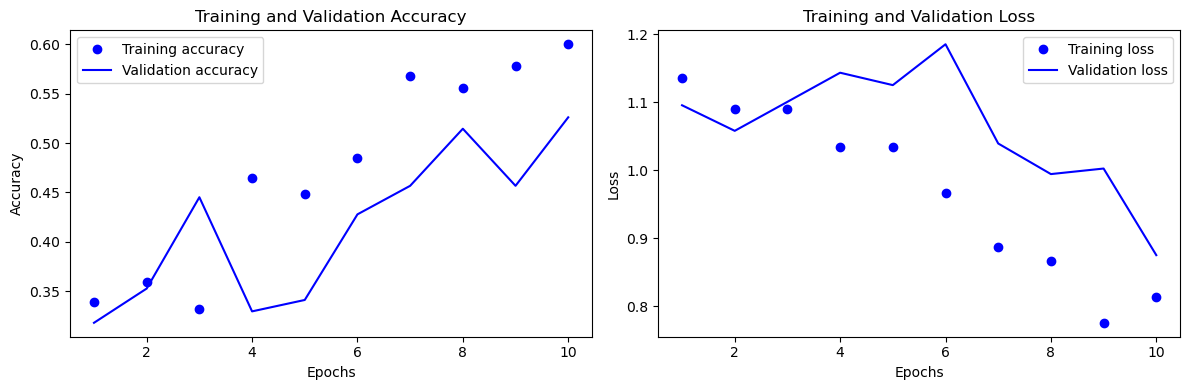

In [8]:
plot_training_history(history)

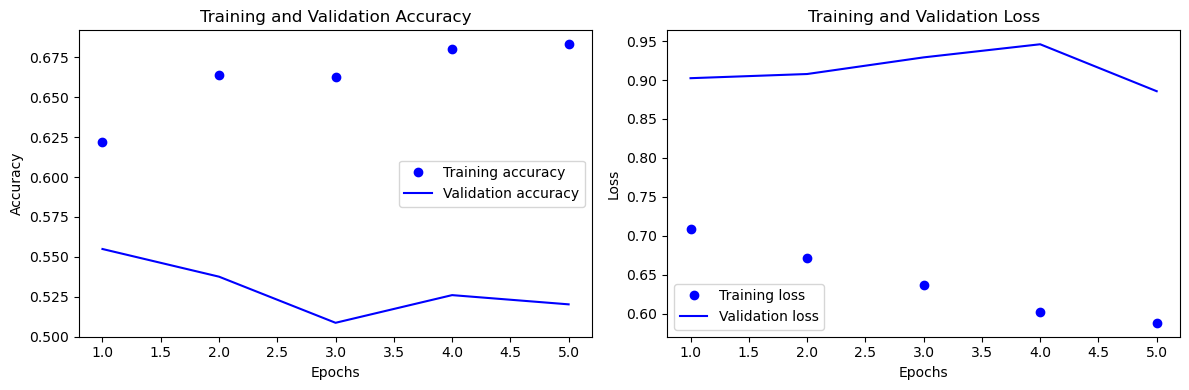

In [10]:
plot_training_history(history2)

In [42]:
test_model = keras.models.load_model("cnn.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.5330 - loss: 0.9065
Test accuracy: 0.526


## Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,   # normalization
    shear_range=15,   # shearing [-15°, 15°]
    width_shift_range=0.15,  # translation [-15, 15]
    height_shift_range=0.15,
    rotation_range=25,  # rotation [-25°, 25°]
    zoom_range=0.2,     # zoom augmentation
    horizontal_flip=True,  # flip augmentation
)

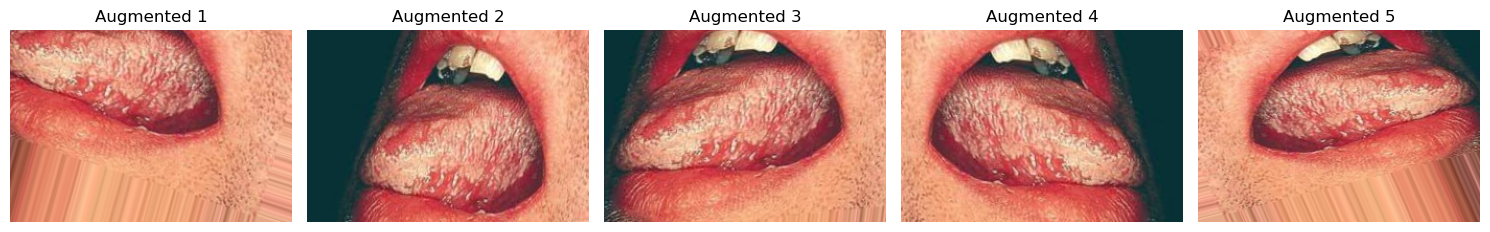

In [15]:
image_path = './oral_cancer_train_test_split/train/oral_cancer/oral_cancer.73.jpg'
image = load_img(image_path)  
image = img_to_array(image)   
image = np.expand_dims(image, axis=0)  

aug_iter = train_datagen.flow(image, batch_size=1)

fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    batch = next(aug_iter)
    ax = axes[i]
    img = batch[0]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Augmented {i+1}')

plt.tight_layout()
plt.show()

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
        'oral_cancer_train_test_split/train/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_data = test_datagen.flow_from_directory(
        'oral_cancer_train_test_split/test/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 685 images belonging to 3 classes.
Found 173 images belonging to 3 classes.


## Pre-trained Model

### ResNet101

In [7]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)

resnet_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# resnet_model.summary()

In [8]:
# train resnet
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="resnet.keras", save_best_only=True, monitor="val_loss") ]

history = resnet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

Epoch 1/10


/home/research/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 161s 7s/step - accuracy: 0.3270 - loss: 1.4957 - val_accuracy: 0.3688 - val_loss: 1.0386
Epoch 2/10
 1/21 ━━━━━━━━━━━━━━━━━━━━ 1:52 6s/step - accuracy: 0.5312 - loss: 1.1247

2024-09-18 13:08:44.821648: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-09-18 13:08:46.966377: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.5312 - loss: 1.1247 - val_accuracy: 0.4615 - val_loss: 1.1457
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 150s 7s/step - accuracy: 0.3632 - loss: 1.2642 - val_accuracy: 0.5063 - val_loss: 1.0313
Epoch 4/10
 1/21 ━━━━━━━━━━━━━━━━━━━━ 1:42 5s/step - accuracy: 0.3438 - loss: 1.2206

2024-09-18 13:11:24.502768: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.3438 - loss: 1.2206 - val_accuracy: 0.5385 - val_loss: 1.0157
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 149s 7s/step - accuracy: 0.4182 - loss: 1.1337 - val_accuracy: 0.4563 - val_loss: 1.0163
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.3750 - loss: 1.0602 - val_accuracy: 0.4615 - val_loss: 1.0431
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 158s 8s/step - accuracy: 0.3724 - loss: 1.1159 - val_accuracy: 0.5938 - val_loss: 1.0064
Epoch 8/10
 1/21 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - accuracy: 0.3438 - loss: 1.1265

2024-09-18 13:16:52.656789: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.3438 - loss: 1.1265 - val_accuracy: 0.6154 - val_loss: 0.9653
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.4012 - loss: 1.1602 - val_accuracy: 0.4875 - val_loss: 1.0291
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.5625 - loss: 1.0648 - val_accuracy: 0.5385 - val_loss: 0.9659


In [10]:
history = resnet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.4155 - loss: 1.0922 - val_accuracy: 0.3187 - val_loss: 1.0106
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.4375 - loss: 1.1085 - val_accuracy: 0.3077 - val_loss: 1.0317
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 148s 7s/step - accuracy: 0.3923 - loss: 1.1215 - val_accuracy: 0.6000 - val_loss: 0.9759
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.3750 - loss: 1.1548 - val_accuracy: 0.4615 - val_loss: 0.9858
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.3898 - loss: 1.0577 - val_accuracy: 0.4750 - val_loss: 0.9888
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.5000 - loss: 0.9866 - val_accuracy: 0.4615 - val_loss: 1.0017
Epoch 7/10


2024-09-18 13:30:01.110276: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 153s 7s/step - accuracy: 0.4348 - loss: 1.0587 - val_accuracy: 0.3750 - val_loss: 0.9881
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.2188 - loss: 1.1924 - val_accuracy: 0.2308 - val_loss: 1.0339
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 152s 7s/step - accuracy: 0.4239 - loss: 1.0397 - val_accuracy: 0.5250 - val_loss: 0.9480
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.3125 - loss: 1.1108 - val_accuracy: 0.6154 - val_loss: 0.9609


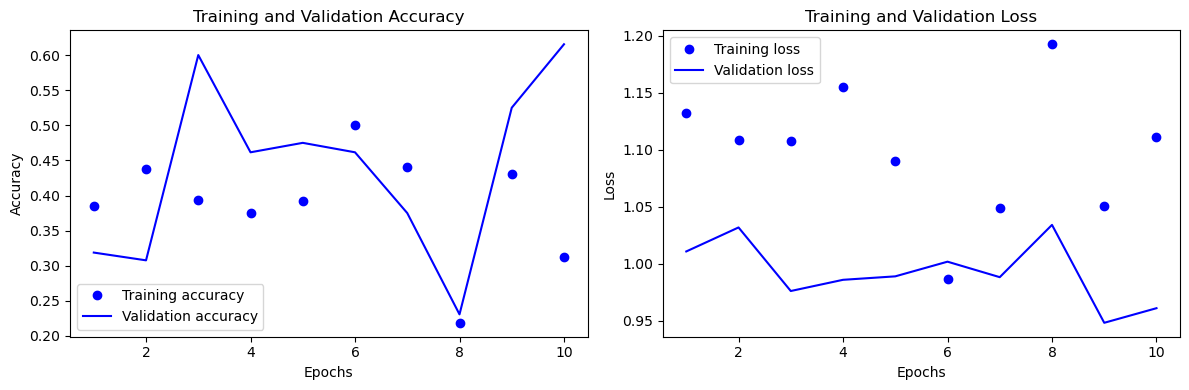

In [19]:
plot_training_history(history)

In [16]:
test_model = keras.models.load_model("resnet.keras")
test_loss, test_acc = test_model.evaluate(validation_dataation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5244 - loss: 0.9324
Test accuracy: 0.526


### VGG16

In [24]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

vgg16_model = Model(inputs=base_model.input, outputs=predictions)

vgg16_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

vgg16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 528,387 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
# train vgg16
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg16.keras", save_best_only=True, monitor="val_loss") ]

history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

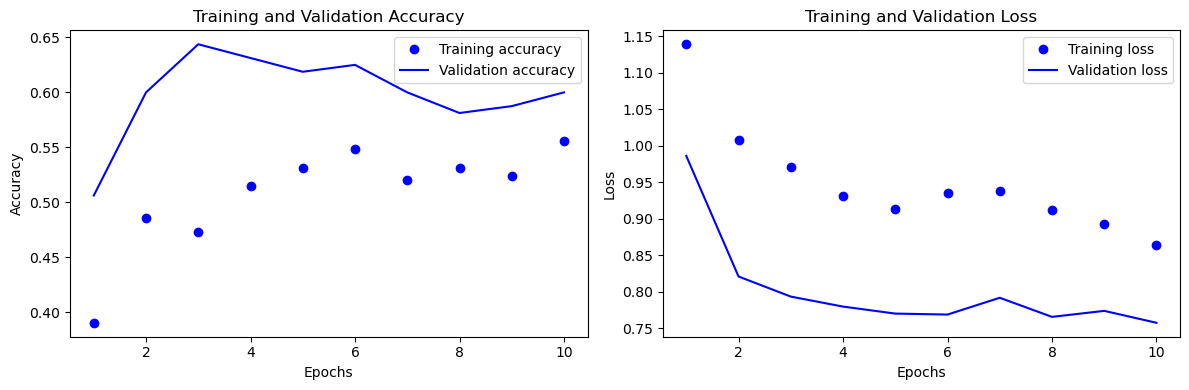

In [34]:
plot_training_history(history)

In [6]:
test_model = keras.models.load_model("vgg16.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

2024-09-19 15:00:42.175175: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-19 15:00:42.175226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tech-desktop): /proc/driver/nvidia/version does not exist
2024-09-19 15:00:43.645180: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2024-09-19 15:00:44.133718: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


1/6 [====>.........................] - ETA: 47s - loss: 0.7134 - accuracy: 0.6562

2024-09-19 15:00:52.510485: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2024-09-19 15:00:52.646732: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


2/6 [=========>....................] - ETA: 33s - loss: 0.7058 - accuracy: 0.6250

2024-09-19 15:01:01.003504: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


6/6 [==============================] - 47s 7s/step - loss: 0.7522 - accuracy: 0.6069
Test accuracy: 0.607


In [29]:
# more training
vgg16_model = keras.models.load_model("vgg16.keras")
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg16.keras", save_best_only=True, monitor="val_loss") ]

history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

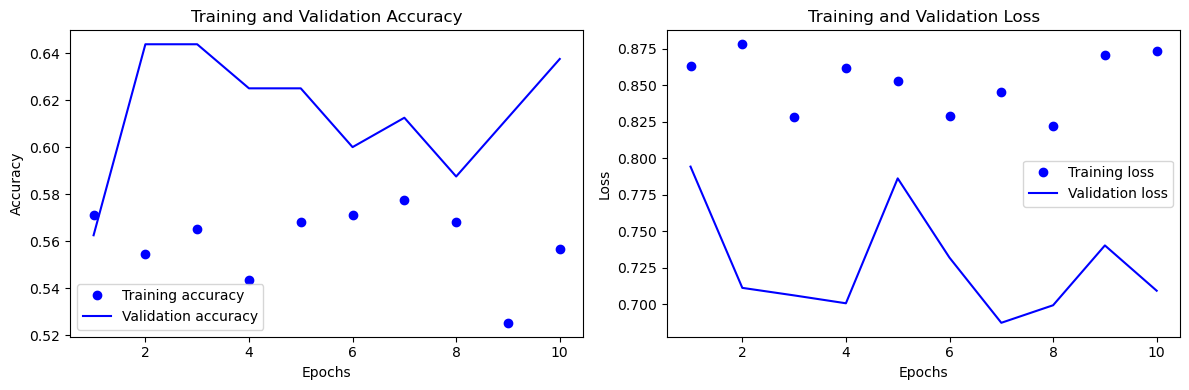

In [7]:
plot_training_history(history)

In [8]:
test_model = keras.models.load_model("vgg16.keras")
test_loss, test_acc = test_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 45s 7s/step - loss: 0.6891 - accuracy: 0.6127
Test accuracy: 0.613
